In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import yfinance as yf
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [ ]:
# Define the path where the tokenizer and model are saved
load_directory = '/content/drive/MyDrive/Final Year Project/twitter_roberta_sentiment'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(load_directory)
model = AutoModelForSequenceClassification.from_pretrained(load_directory)

In [ ]:
# Override how Pandas Datareader reads data
yf.pdr_override()

# Define the list of stocks you want to download
stocks = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS',
          'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS',
          'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
          'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS',
          'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS',
          'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LTIM.NS', 'LT.NS',
          'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS',
          'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS',
          'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS',
          'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']

# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year, today.month-5, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.
2024-01-29 00:00:00
2024-06-29 00:00:00


In [ ]:
# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

stock = 'TCS.NS'

# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

# Download data from Yahoo Finance
df = yf.download(stock, start=start, end=end)

# Ticker for searching news
stockraw = stock[:-3]

# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
soup = BeautifulSoup(webpage, 'html.parser')

# Extract titles and dates
titles = soup.find_all('a', class_='JtKRv')
datetimes = soup.find_all('time', class_='hvbAAd')

# Create lists to store extracted data
dates_list = []
titles_list = []

for title, datetime_tag in zip(titles, datetimes):
    # Remove leading/trailing whitespace from title
    title_text = title.text.strip()
    datetime_str = datetime_tag['datetime']

    # Parse datetime string
    formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')

    # Append data to respective lists
    dates_list.append(formatted_datetime.date())
    titles_list.append(title_text)

# Create DataFrame
df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)

# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

# Isolating features for training
cols = list(merged_df)[1:8]

# Storing all data for scaling
df_for_scaling = merged_df[cols]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the numerical data
scaled_numerical_data = scaler.fit_transform(df_for_scaling)

# Create a new DataFrame for the scaled data
df_scaled = df_for_scaling.copy()
df_scaled[cols] = scaled_numerical_data

# Add a column for the stock ticker
df_scaled['Stock'] = stock

# Add all data to the following dataframe
all_stock_data = pd.concat([all_stock_data, df_scaled])

print(all_stock_data)

[*********************100%%**********************]  1 of 1 completed
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


         Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0    0.195633  0.147131  0.323399  0.237188   0.198169  0.085861    0.530371   
1    0.208539  0.201668  0.333903  0.236367   0.197307  0.062775    0.530371   
2    0.215817  0.174595  0.350043  0.264454   0.226830  0.165650    0.530371   
3    0.232897  0.313683  0.364731  0.334124   0.300063  0.156200    0.530371   
4    0.339738  0.469642  0.479078  0.538665   0.515067  0.201700    0.530371   
..        ...       ...       ...       ...        ...       ...         ...   
97   0.211063  0.219716  0.341247  0.266004   0.281643  0.091302    0.571208   
98   0.227074  0.201373  0.343979  0.305490   0.323449  0.055625    0.610277   
99   0.280446  0.239235  0.426132  0.337224   0.357050  0.085184    0.566236   
100  0.254246  0.386464  0.387020  0.480029   0.508250  0.368625    0.649319   
101  0.422708  0.421775  0.523228  0.425314   0.450319  0.192378    0.642500   

      Stock  
0    TCS.NS  
1    TCS.NS

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(all_stock_data)

# Define all possible categories for the 'Stock' column
all_categories = sorted(stocks)

# Convert the 'Stock' column to a categorical type with the specified categories
df['Stock'] = pd.Categorical(df['Stock'], categories=all_categories)

# One hot encoding using pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['Stock'], dummy_na=False)
print(df_encoded)

cols = list(df_encoded)[7:57]


# Ensure the columns are integer type (0 and 1) instead of boolean
df_encoded[cols] = df_encoded[cols].astype(int)

# Print the one hot encoded DataFrame
print(df_encoded)

         Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0    0.195633  0.147131  0.323399  0.237188   0.198169  0.085861    0.530371   
1    0.208539  0.201668  0.333903  0.236367   0.197307  0.062775    0.530371   
2    0.215817  0.174595  0.350043  0.264454   0.226830  0.165650    0.530371   
3    0.232897  0.313683  0.364731  0.334124   0.300063  0.156200    0.530371   
4    0.339738  0.469642  0.479078  0.538665   0.515067  0.201700    0.530371   
..        ...       ...       ...       ...        ...       ...         ...   
97   0.211063  0.219716  0.341247  0.266004   0.281643  0.091302    0.571208   
98   0.227074  0.201373  0.343979  0.305490   0.323449  0.055625    0.610277   
99   0.280446  0.239235  0.426132  0.337224   0.357050  0.085184    0.566236   
100  0.254246  0.386464  0.387020  0.480029   0.508250  0.368625    0.649319   
101  0.422708  0.421775  0.523228  0.425314   0.450319  0.192378    0.642500   

     Stock_ADANIENT.NS  Stock_ADANIPORT

In [ ]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window + 1):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 'Sentiments']].iloc[i + window - 1].values)
	return np.array(xRes), np.array(yRes)

In [ ]:
# Dataset splitting
SPLIT = 1.00
(X_test, y_test) = singleStepSampler(df_encoded, 20)
print(X_test.shape)
print(y_test.shape)

(83, 20, 57)
(83, 7)


In [ ]:
# Load the model
multivariate_lstm = load_model("/content/drive/MyDrive/Final Year Project/multivariate_lstm_model3.h5")

# Verify the loaded model
multivariate_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 200)           206400    
                                                                 
 dropout_6 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               120400    
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 327507 (1.25 MB)
Trainable params: 327507 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 0s 20ms/step


Root Mean Square of Scaled Predictions
RMSE for Open prices: 0.09372758994263627
RMSE for Close prices: 0.03407747491003302



Root Mean Square of Inverse Scaled Predictions
RMSE for Open prices: 48.29314997126951
RMSE for Close prices: 17.3710002471824





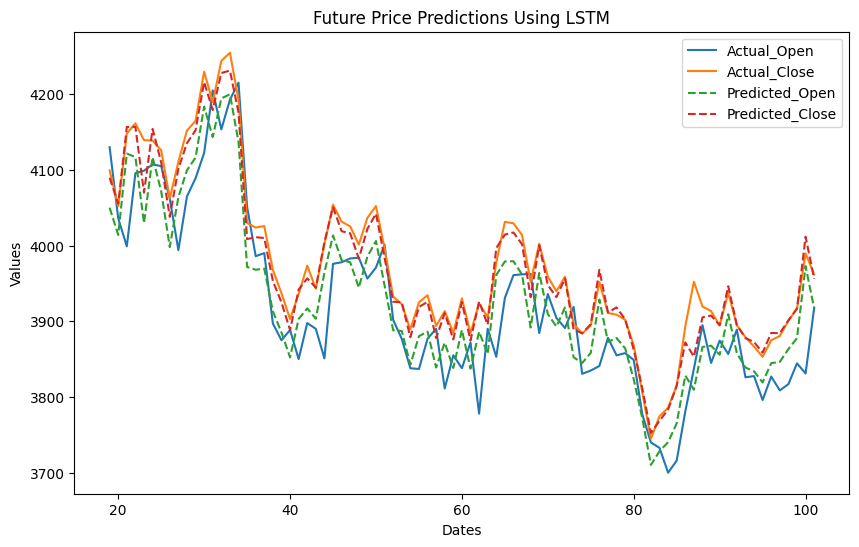

In [ ]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

# Data frame to calculate RMSE
d = {
	'Predicted_Open': predicted_values[:, 0],
	'Predicted_Close': predicted_values[:, 1],
	'Actual_Open': y_test[:, 0],
	'Actual_Close': y_test[:, 1],
}
print("\n\nRoot Mean Square of Scaled Predictions")
# Calculate RMSE for Open prices
rmse_open = mean_squared_error(d['Actual_Open'], d['Predicted_Open'], squared=False)

# Calculate RMSE for Close prices
rmse_close = mean_squared_error(d['Actual_Close'], d['Predicted_Close'], squared=False)

print(f'RMSE for Open prices: {rmse_open}')
print(f'RMSE for Close prices: {rmse_close}')
print("\n\n")

# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test)
predicted_values_inv = scaler.inverse_transform(predicted_values)

# Create the DataFrame with inverse-transformed data
d = {
    'Predicted_Open': predicted_values_inv[:, 0],
    'Predicted_Close': predicted_values_inv[:, 1],
    'Actual_Open': y_test_inv[:, 0],
    'Actual_Close': y_test_inv[:, 1],
}
print("Root Mean Square of Inverse Scaled Predictions")
# Calculate RMSE for Open prices
rmse_open = mean_squared_error(d['Actual_Open'], d['Predicted_Open'], squared=False)

# Calculate RMSE for Close prices
rmse_close = mean_squared_error(d['Actual_Close'], d['Predicted_Close'], squared=False)

print(f'RMSE for Open prices: {rmse_open}')
print(f'RMSE for Close prices: {rmse_close}')
print("\n\n")

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
#plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])
plt.plot(d[['Actual_Open', 'Actual_Close']], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
#plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Future Price Predictions Using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [ ]:
# Code to make future predictions
df_scaled_duplicate = df_encoded[-19:]
X_test_duplicate = X_test[-30:, :, :]
y_test_duplicate = y_test[-30:, :]
p = 6

for i in range (p):
    print(i)

    # Make prediction
    predicted_values = multivariate_lstm.predict(X_test_duplicate)

    # Convert the predicted values into a dataframe
    df_predicted_values = pd.DataFrame(predicted_values)

    # Name the columns
    df_predicted_values.columns = list(df_scaled_duplicate.columns[:7])

    # Add stock column to perform one hot encoding
    df_predicted_values['Stock'] = stock

    # Convert the 'Stock' column to a categorical type with the specified categories
    df_predicted_values['Stock'] = pd.Categorical(df_predicted_values['Stock'], categories=all_categories)

    # One hot encoding using pd.get_dummies
    df_predicted_values_encoded = pd.get_dummies(df_predicted_values, columns=['Stock'], dummy_na=False)

    # Ensure the columns are integer type (0 and 1) instead of boolean
    cols = list(df_predicted_values_encoded)[7:57]
    df_predicted_values_encoded[cols] = df_predicted_values_encoded[cols].astype(int)

    # Select the last row of the predictions dataframe
    last_row = df_predicted_values_encoded.iloc[[-1]]

    # Append the last row to df_scaled_duplicate using pd.concat
    df_scaled_duplicate = pd.concat([df_scaled_duplicate, last_row], ignore_index=True)

    # Convert the data into a window
    (xVal2, yVal2) = singleStepSampler(df_scaled_duplicate, 20)

    # Delete the first row from the dataset
    df_scaled_duplicate = df_scaled_duplicate.drop(df_scaled_duplicate.index[0])

    # Append xVal2 to X_test_duplicate
    X_test_duplicate = np.concatenate([X_test_duplicate, xVal2], axis=0)

0
1/1 [==============================] - 0s 54ms/step
1
1/1 [==============================] - 0s 54ms/step
2
1/1 [==============================] - 0s 60ms/step
3
2/2 [==============================] - 0s 23ms/step
4
2/2 [==============================] - 0s 17ms/step
5
2/2 [==============================] - 0s 17ms/step


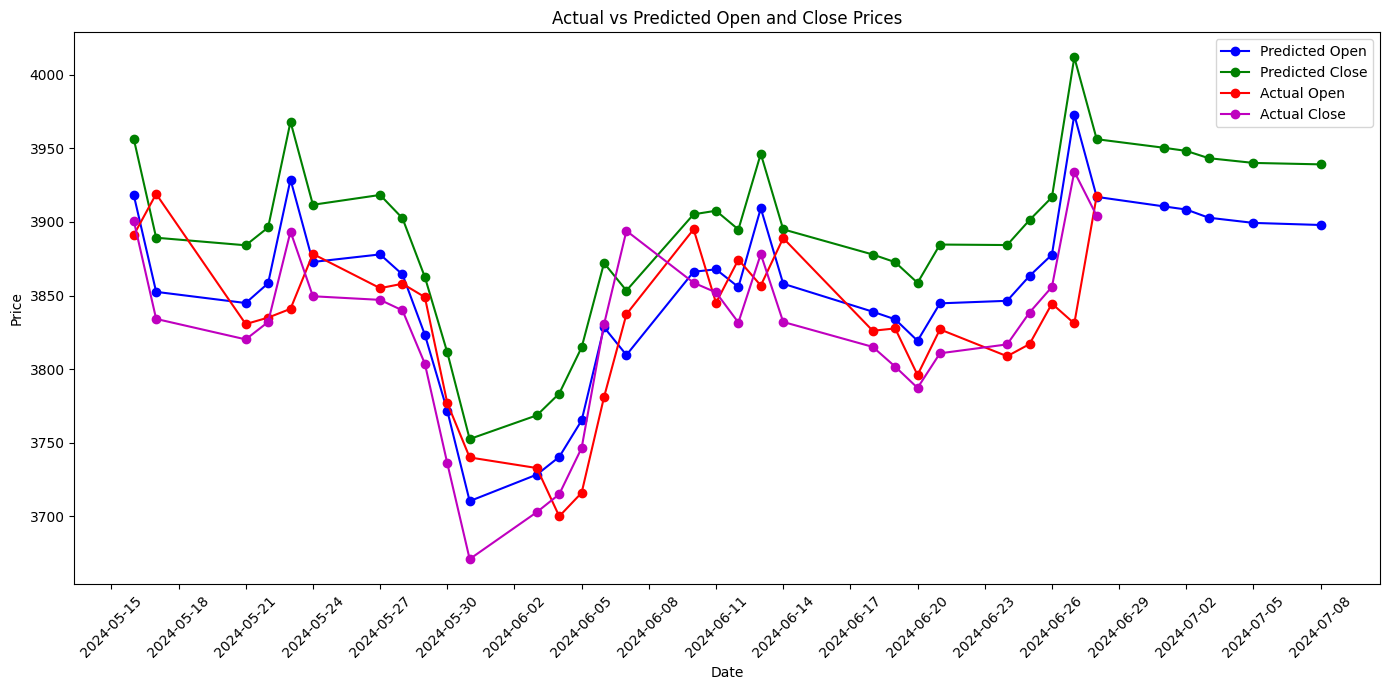

In [ ]:
# Isolating dates of actual data
merged_df_duplicate = merged_df[-30:].reset_index(drop=True)
train_dates = pd.to_datetime(merged_df_duplicate['Date'])

# Assuming train_dates is already defined and is a pandas Series or array of dates
train_dates = pd.to_datetime(train_dates)

# Define custom business day with US Federal Holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Get the last date from train_dates
last_train_date = train_dates.max()

# Generate the next 5 business days after the last date in train_dates
n_days_for_prediction = p - 1
predict_period_dates = pd.date_range(last_train_date, periods=n_days_for_prediction + 1, freq=us_bd)[1:].tolist()

# Convert timestamp to date
forecast_dates = [time_i.date() for time_i in predict_period_dates]

# Merge train_dates and forecast_dates
all_dates = list(train_dates.dt.date) + forecast_dates

# Convert all dates into a DataFrame
all_dates_df = pd.DataFrame(all_dates, columns=['Date'])

# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test_duplicate)
predicted_values_inv = scaler.inverse_transform(predicted_values)

# Create a DataFrame for predicted values
d_predicted = {
    'Date': all_dates_df['Date'],
    'Predicted_Open': predicted_values_inv[:, 0],
    'Predicted_Close': predicted_values_inv[:, 1],
}
df_predicted = pd.DataFrame(d_predicted)

# Select the last 30 rows of merged_df and reset the index
merged_df_duplicate = merged_df[-30:].reset_index(drop=True)

# Create a DataFrame for actual values
d_actual = {
    'Date': all_dates_df['Date'][:30],
    'Actual_Open': merged_df_duplicate['Open'][-30:],
    'Actual_Close': merged_df_duplicate['Close'][-30:],
}
df_actual = pd.DataFrame(d_actual)

# Plotting
plt.figure(figsize=(14, 7))

# Plot predicted values
plt.plot(df_predicted['Date'], df_predicted['Predicted_Open'], marker='o', linestyle='-', color='b', label='Predicted Open')
plt.plot(df_predicted['Date'], df_predicted['Predicted_Close'], marker='o', linestyle='-', color='g', label='Predicted Close')

# Plot actual values
plt.plot(df_actual['Date'], df_actual['Actual_Open'], marker='o', linestyle='-', color='r', label='Actual Open')
plt.plot(df_actual['Date'], df_actual['Actual_Close'], marker='o', linestyle='-', color='m', label='Actual Close')

# Format the plot
plt.title('Actual vs Predicted Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

# Increase the frequency of x-axis ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))

plt.legend()

plt.tight_layout()
plt.show()